# Data Exploration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
test = np.load("./Data/test_images.npy")
test.shape

(10000, 28, 28)

In [3]:
train = np.load("./Data/train_images.npy")
train.shape

(60000, 28, 28)

In [4]:
labels = pd.read_csv("./Data/train_labels.csv")
labels.head()

,label
0,9
1,0
2,0
3,3
4,0


array([[<Axes: title={'center': 'label'}>]], dtype=object)

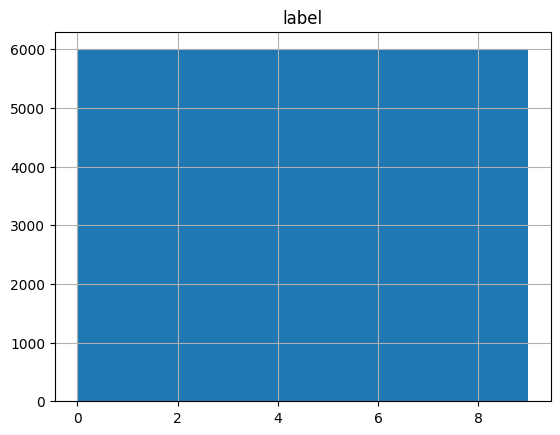

In [5]:
labels.hist()


TypeError: Invalid shape (10, 28, 28) for image data

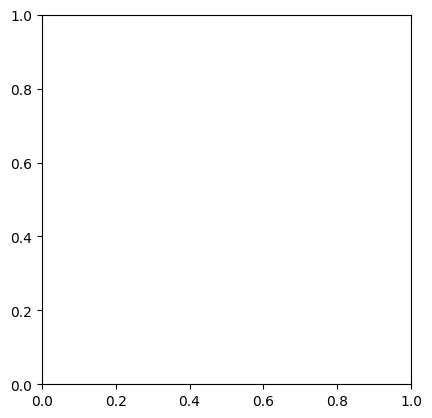

In [48]:
preProc = pd.DataFrame({'clothes': []})

plt.imshow([train[labels.label.values == i].mean(axis=0) for i in range(10)])
    